<a href="https://colab.research.google.com/github/bhattacharjee/msc-ai-project/blob/main/iteration_3.0.ipynb/Autoencoder_iteration_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging, sys, random, glob
from google.colab import drive
from functools import lru_cache
import sklearn
from sklearn.model_selection import train_test_split

from tensorflow import keras as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import IPython


drive.mount("/content/drive")

def set_random_seed():
    np.random.seed(1)
    random.seed(1)
    tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

!cp -r /content/drive/MyDrive/MSCPROJDATA .

Mounted at /content/drive


In [ ]:
class Plot:
    def __init__(self):
        self.history = {}
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', \
                       'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
                       'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    def plot_history(self, history, N_EPOCHS, name, show=True):
        if show:
            N_EPOCHS = len(history.history["loss"])
            plt.rcParams["figure.figsize"] = (20, 10)
            plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
            plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
            plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
            plt.legend()
            plt.show()
        best_val_acc = max(history.history['val_accuracy'])
        index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
        best_val_loss = min(history.history['val_loss'])
        index_best_val_loss = history.history['val_loss'].index(best_val_loss)
        if show:
            print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
            print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
        entry = Entry(\
                      loss=history.history["loss"],\
                      val_loss=history.history["val_loss"],\
                      accuracy=history.history["accuracy"],\
                      val_accuracy=history.history["val_accuracy"],\
                      best_accuracy=best_val_acc,
                      best_loss=best_val_loss)
        self.history[name] = entry
        gc.collect()

    def superplot(self):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
            innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
            innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
            innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
            i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()


    def superplot_contains_string(self, match):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            if match.lower() in name.lower():
                innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
                innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
                innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
                innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
                i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()

    def superplot_notcontains_string(self, match):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            if not (match.lower() in name.lower()):
                innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
                innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
                innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
                innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
                i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()


In [3]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    baseline_and_advanced = list(set(baseline_columns + advanced_columns_only))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns_only))
    advanced_and_fourier = list(set(advanced_columns_only + fourier_columns_only))
    
    return {\
        "baseline": baseline_columns,\
        "advanced-only": advanced_columns_only,\
        "fourier-only": fourier_columns_only,\
        "baseline-and-fourier": baseline_and_fourier,\
        "advanced-and-fourier": advanced_and_fourier,\
        "advanced": advanced_columns,\
        "fourier": fourier_columns,\
    }

@lru_cache(maxsize=5)
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("MSCPROJDATA/**.parquet.gz", recursive=True):
        print(f"Loading {file}")
        df = pd.read_parquet(file)
        df = df.sample(frac=1).reset_index(drop=True)
        df["is_encrypted"] = 1 if "encr" in file.lower() else 0
        datasets[file] = df
    return datasets

In [7]:
all_datasets = load_datasets_once()
full_dataset = pd.concat(all_datasets.values())
encrypted_df = full_dataset[full_dataset["is_encrypted"] == 1]
non_encrypted_df = full_dataset[full_dataset["is_encrypted"] == 0]

# shuffle
encrypted_df = encrypted_df.sample(frac=1).reset_index(drop=True)
non_encrypted_df = non_encrypted_df.sample(frac=1).reset_index(drop=True)

columns = []
for c in get_columns(full_dataset).values():
    columns += c
columns = list(set(columns))

work_encrypted_df_X = encrypted_df[columns]
work_encrypted_df_y = encrypted_df["is_encrypted"]
work_non_encrypted_df_X = non_encrypted_df[columns]
work_non_encrypted_df_y = non_encrypted_df["is_encrypted"]

def normalize_df(X, Y):
    mindf = X.min()
    maxdf = X.max()
    X = (X - mindf) / (maxdf - mindf)
    Y = (Y - mindf) / (maxdf - mindf)
    return X, Y

work_encrypted_df_X, work_non_encrypted_df_X = \
    normalize_df(
        work_encrypted_df_X,
        work_non_encrypted_df_X
    )

In [8]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(\
        work_encrypted_df_X,
        work_encrypted_df_y,
        test_size=0.33,
        random_state=42)

X_train.shape

(216686, 63)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                4096      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                544       
                                                                 
 dropout_2 (Dropout)         (None, 32)               

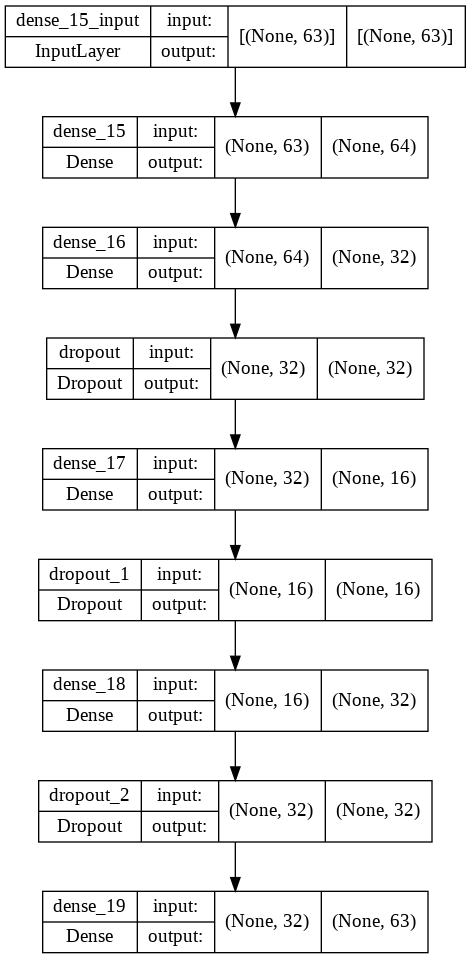

(173348, 63) (43338, 63)
Epoch 1/10
10835/10835 [==============================] - 50s 5ms/step - loss: 0.0032 - mae: 0.0217 - mse: 0.0032 - val_loss: 4.4383e-04 - val_mae: 0.0090 - val_mse: 4.4383e-04
Epoch 2/10
10835/10835 [==============================] - 48s 4ms/step - loss: 9.2854e-04 - mae: 0.0121 - mse: 9.2854e-04 - val_loss: 3.8554e-04 - val_mae: 0.0084 - val_mse: 3.8554e-04
Epoch 3/10
10835/10835 [==============================] - 44s 4ms/step - loss: 8.6499e-04 - mae: 0.0116 - mse: 8.6499e-04 - val_loss: 3.7317e-04 - val_mae: 0.0080 - val_mse: 3.7317e-04
Epoch 4/10
10835/10835 [==============================] - 44s 4ms/step - loss: 8.3203e-04 - mae: 0.0113 - mse: 8.3203e-04 - val_loss: 3.9630e-04 - val_mae: 0.0085 - val_mse: 3.9630e-04
Epoch 5/10
10835/10835 [==============================] - 44s 4ms/step - loss: 8.0551e-04 - mae: 0.0111 - mse: 8.0551e-04 - val_loss: 3.3049e-04 - val_mae: 0.0076 - val_mse: 3.3049e-04
Epoch 6/10
10835/10835 [==============================] - 

In [ ]:


class Autoencoder:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                layers.Dropout(0.25),
                layers.Dense(16, activation='relu'),
                layers.Dropout(0.25),
                layers.Dense(32, activation='relu'),
                layers.Dropout(0.25),
                layers.Dense(63, activation='sigmoid'),
            ]
        )
        return model



def print_and_plot(model):
    print(model.summary())
    plot = tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        expand_nested=True)
    IPython.display.display(plot)


from sklearn.model_selection import train_test_split
def create_and_train_autoencoder(X, y):
    X_train, X_eval, y_train, y_eval= \
        train_test_split(X, y, test_size=0.2, random_state=42)

    nn = Autoencoder.build()
    nn.compile(optimizer='adam', loss='mse', metrics=["mae", "mse"])

    nn.build((None, X.shape[1]))
    print_and_plot(nn)

    print(X_train.shape, X_eval.shape)
    history = nn.fit(X_train, X_train,
                epochs=10,
                validation_data=(X_eval, X_eval),
                batch_size=16)
    return nn, history

nn, history = create_and_train_autoencoder(X_train, y_train)

(216686, 63)
